## 1. Importing Libraries

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## 2. EDA (Exploratory of Data Analysis)
### 2.1. Data Preperation

In [2]:
#Reading the dataset
input = 'diabetes.csv'
df = pd.read_csv(input)

In [3]:
df.shape

(768, 9)

In [4]:
df.describe([0.10,0.25,0.50,0.75,0.90,0.95,0.99]).T

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
Pregnancies,768.0,3.845052,3.369578,0.000,0.000,1.00000,3.0000,6.00000,9.0000,10.00000,13.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,85.000,99.00000,117.0000,140.25000,167.0000,181.00000,196.00000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,54.000,62.00000,72.0000,80.00000,88.0000,90.00000,106.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.000,0.00000,23.0000,32.00000,40.0000,44.00000,51.33000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.000,0.00000,30.5000,127.25000,210.0000,293.00000,519.90000,846.00
BMI,768.0,31.992578,7.884160,0.000,23.600,27.30000,32.0000,36.60000,41.5000,44.39500,50.75900,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.165,0.24375,0.3725,0.62625,0.8786,1.13285,1.69833,2.42
Age,768.0,33.240885,11.760232,21.000,22.000,24.00000,29.0000,41.00000,51.0000,58.00000,67.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.000,0.00000,0.0000,1.00000,1.0000,1.00000,1.00000,1.00


In [5]:
df["Outcome"].value_counts()*100/len(df)

Outcome
0    65.104167
1    34.895833
Name: count, dtype: float64

In [6]:
df.Outcome.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

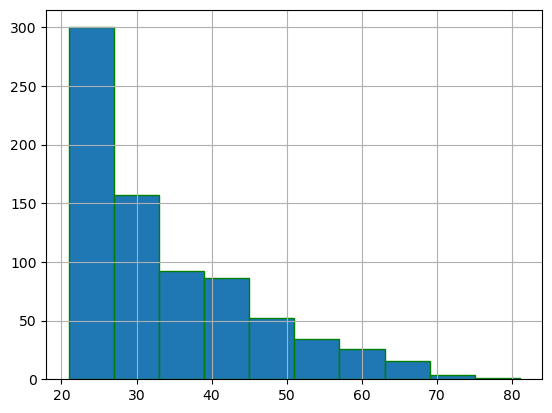

In [7]:
df["Age"].hist(edgecolor = "green");

## 3. Missing Value Analysis

In [8]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.NaN)

In [10]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [11]:
# The missing values will be filled with the median values of each variable.

def median_target(var):

    temp = df[df[var].notnull()]

    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].mean().reset_index()

    return temp

In [12]:
columns = df.columns

columns = columns.drop("Outcome")

In [13]:
columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [14]:
median_target('Glucose')

,Outcome,Glucose
0,0,110.643863
1,1,142.319549


In [15]:
# The values to be given for incomplete observations are given the median value of people who are not sick and the median values of people who are sick.

columns = df.columns

columns = columns.drop("Outcome")

for col in columns:

    df.loc[(df['Outcome'] == 0 ) & (df[col].isnull()), col] = median_target(col)[col][0]
    df.loc[(df['Outcome'] == 1 ) & (df[col].isnull()), col] = median_target(col)[col][1]

In [17]:
df.loc[(df['Outcome'] == 0 ) & (df["Pregnancies"].isnull()), "Pregnancies"]

Series([], Name: Pregnancies, dtype: float64)

In [18]:
df[(df['Outcome'] == 0 ) & (df["BloodPressure"].isnull())]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


## 4. Outliers Analysis

In [18]:
Q1 = df["BloodPressure"].quantile(0.25)
Q3 = df["BloodPressure"].quantile(0.75)
IQR = Q3-Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
print(lower)
print(upper)

40.0
104.0


In [19]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,206.846154,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,130.287879,26.6,0.351,31.0,0
2,8.0,183.0,64.0,33.0,206.846154,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.000000,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.000000,43.1,2.288,33.0,1


In [20]:
df.shape

(768, 9)

## 5. Feature Engineering

In [21]:
# According to BMI, some ranges were determined and categorical variables were assigned.
NewBMI = pd.Series(["Underweight", "Normal", "Overweight", "Obesity 1", "Obesity 2", "Obesity 3"], dtype = "category")

df["NewBMI"] = NewBMI

df.loc[df["BMI"] < 18.5, "NewBMI"] = NewBMI[0]

df.loc[(df["BMI"] > 18.5) & (df["BMI"] <= 24.9), "NewBMI"] = NewBMI[1]
df.loc[(df["BMI"] > 24.9) & (df["BMI"] <= 29.9), "NewBMI"] = NewBMI[2]
df.loc[(df["BMI"] > 29.9) & (df["BMI"] <= 34.9), "NewBMI"] = NewBMI[3]
df.loc[(df["BMI"] > 34.9) & (df["BMI"] <= 39.9), "NewBMI"] = NewBMI[4]
df.loc[df["BMI"] > 39.9 ,"NewBMI"] = NewBMI[5]

In [22]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI
0,6.0,148.0,72.0,35.0,206.846154,33.6,0.627,50.0,1,Obesity 1
1,1.0,85.0,66.0,29.0,130.287879,26.6,0.351,31.0,0,Overweight
2,8.0,183.0,64.0,33.0,206.846154,23.3,0.672,32.0,1,Normal
3,1.0,89.0,66.0,23.0,94.000000,28.1,0.167,21.0,0,Overweight
4,0.0,137.0,40.0,35.0,168.000000,43.1,2.288,33.0,1,Obesity 3


In [23]:
def set_insulin(row):
    if row["Insulin"] >= 16 and row["Insulin"] <= 166:
        return "Normal"
    else:
        return "Abnormal"

In [24]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI
0,6.0,148.0,72.0,35.0,206.846154,33.6,0.627,50.0,1,Obesity 1
1,1.0,85.0,66.0,29.0,130.287879,26.6,0.351,31.0,0,Overweight
2,8.0,183.0,64.0,33.0,206.846154,23.3,0.672,32.0,1,Normal
3,1.0,89.0,66.0,23.0,94.000000,28.1,0.167,21.0,0,Overweight
4,0.0,137.0,40.0,35.0,168.000000,43.1,2.288,33.0,1,Obesity 3


In [25]:
df["NewInsulinScore"] = df.apply(set_insulin, axis=1)

In [26]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulinScore
0,6.0,148.0,72.0,35.0,206.846154,33.6,0.627,50.0,1,Obesity 1,Abnormal
1,1.0,85.0,66.0,29.0,130.287879,26.6,0.351,31.0,0,Overweight,Normal
2,8.0,183.0,64.0,33.0,206.846154,23.3,0.672,32.0,1,Normal,Abnormal
3,1.0,89.0,66.0,23.0,94.000000,28.1,0.167,21.0,0,Overweight,Normal
4,0.0,137.0,40.0,35.0,168.000000,43.1,2.288,33.0,1,Obesity 3,Abnormal


In [27]:
#df.drop("NewInsulinScore", inplace = True, axis = 1)
#df.head()

In [28]:
# Some intervals were determined according to the glucose variable and these were assigned categorical variables.
NewGlucose = pd.Series(["Low", "Normal", "Overweight", "Secret", "High"], dtype = "category")

df["NewGlucose"] = NewGlucose

df.loc[df["Glucose"] <= 70, "NewGlucose"] = NewGlucose[0]

df.loc[(df["Glucose"] > 70) & (df["Glucose"] <= 99), "NewGlucose"] = NewGlucose[1]

df.loc[(df["Glucose"] > 99) & (df["Glucose"] <= 126), "NewGlucose"] = NewGlucose[2]

df.loc[df["Glucose"] > 126 ,"NewGlucose"] = NewGlucose[3]

In [29]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulinScore,NewGlucose
0,6.0,148.0,72.0,35.0,206.846154,33.6,0.627,50.0,1,Obesity 1,Abnormal,Secret
1,1.0,85.0,66.0,29.0,130.287879,26.6,0.351,31.0,0,Overweight,Normal,Normal
2,8.0,183.0,64.0,33.0,206.846154,23.3,0.672,32.0,1,Normal,Abnormal,Secret
3,1.0,89.0,66.0,23.0,94.000000,28.1,0.167,21.0,0,Overweight,Normal,Normal
4,0.0,137.0,40.0,35.0,168.000000,43.1,2.288,33.0,1,Obesity 3,Abnormal,Secret


## 6. One-hot Encoding

In [30]:
df = pd.get_dummies(df, columns =["NewBMI","NewInsulinScore", "NewGlucose"], drop_first = True)

In [31]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
0,6.0,148.0,72.0,35.0,206.846154,33.6,0.627,50.0,1,True,False,False,False,False,False,False,False,False,True
1,1.0,85.0,66.0,29.0,130.287879,26.6,0.351,31.0,0,False,False,False,True,False,True,False,True,False,False
2,8.0,183.0,64.0,33.0,206.846154,23.3,0.672,32.0,1,False,False,False,False,False,False,False,False,False,True
3,1.0,89.0,66.0,23.0,94.000000,28.1,0.167,21.0,0,False,False,False,True,False,True,False,True,False,False
4,0.0,137.0,40.0,35.0,168.000000,43.1,2.288,33.0,1,False,False,True,False,False,False,False,False,False,True


In [32]:
categorical_df = df[['NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
                     'NewInsulinScore_Normal','NewGlucose_Low','NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret']]

## 7. Feature Standartization

In [33]:
y = df["Outcome"]
X = df.drop(["Outcome",'NewBMI_Obesity 1','NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight','NewBMI_Underweight',
                     'NewInsulinScore_Normal','NewGlucose_Low','NewGlucose_Normal', 'NewGlucose_Overweight', 'NewGlucose_Secret'], axis = 1)
cols = X.columns
index = X.index

In [34]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [35]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6.0,148.0,72.0,35.0,206.846154,33.6,0.627,50.0
1,1.0,85.0,66.0,29.0,130.287879,26.6,0.351,31.0
2,8.0,183.0,64.0,33.0,206.846154,23.3,0.672,32.0
3,1.0,89.0,66.0,23.0,94.000000,28.1,0.167,21.0
4,0.0,137.0,40.0,35.0,168.000000,43.1,2.288,33.0


In [36]:
cols

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [37]:
index

RangeIndex(start=0, stop=768, step=1)

In [38]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = cols, index = index)

In [39]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.6,0.751515,0.000,0.875,0.897033,0.170330,0.665359,1.235294
1,-0.4,-0.775758,-0.375,0.125,0.000000,-0.598901,-0.056209,0.117647
2,1.0,1.600000,-0.500,0.625,0.897033,-0.961538,0.783007,0.176471
3,-0.4,-0.678788,-0.375,-0.625,-0.425185,-0.434066,-0.537255,-0.470588
4,-0.6,0.484848,-2.000,0.875,0.441873,1.214286,5.007843,0.235294


In [40]:
X = pd.concat([X, categorical_df], axis = 1)

In [41]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Overweight,NewGlucose_Secret
0,0.6,0.751515,0.000,0.875,0.897033,0.170330,0.665359,1.235294,True,False,False,False,False,False,False,False,False,True
1,-0.4,-0.775758,-0.375,0.125,0.000000,-0.598901,-0.056209,0.117647,False,False,False,True,False,True,False,True,False,False
2,1.0,1.600000,-0.500,0.625,0.897033,-0.961538,0.783007,0.176471,False,False,False,False,False,False,False,False,False,True
3,-0.4,-0.678788,-0.375,-0.625,-0.425185,-0.434066,-0.537255,-0.470588,False,False,False,True,False,True,False,True,False,False
4,-0.6,0.484848,-2.000,0.875,0.441873,1.214286,5.007843,0.235294,False,False,True,False,False,False,False,False,False,True


In [42]:
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=42)

## 8. Model

In [43]:
models = []
models.append(('LR', LogisticRegression(random_state = 42)))
models.append(('CART', DecisionTreeClassifier(random_state = 42)))
models.append(('RF', RandomForestClassifier(random_state = 42)))
models.append(('SVM', SVC(gamma='auto', random_state = 42)))
models.append(('XGB', GradientBoostingClassifier(random_state = 42)))

# evaluate each model in turn
results = []
names = []

for name, model in models:

        kfold = KFold(n_splits=10, shuffle=True)

        cv_results = cross_val_score(model, X, y, cv =4, scoring= "accuracy")
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)




LR: 0.841146 (0.024009)
CART: 0.863281 (0.024808)
RF: 0.865885 (0.019269)
SVM: 0.846354 (0.017077)
XGB: 0.882812 (0.038714)


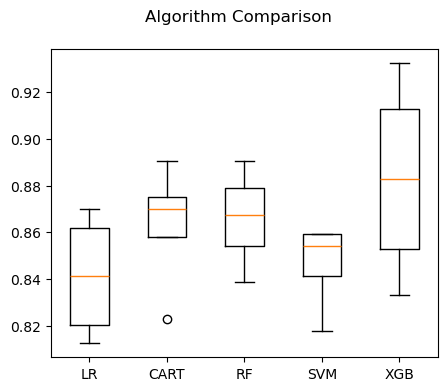

In [44]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(5,4))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()



## 9. Model Optimization (Model Tunning) 

### 9.1. Random Forests Tuning

In [45]:
rf_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

In [46]:
rf_model = RandomForestClassifier(random_state = 42)

In [47]:
gs_cv = GridSearchCV(rf_model,
                    rf_params,
                    cv = 4,
                    refit='recall')


In [48]:
%%time
gs_cv.fit(X,y)

CPU times: total: 3.47 s
Wall time: 4.27 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall')

In [49]:
gs_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

### 9.1.1. RF Final Model

In [50]:
rf_tuned = RandomForestClassifier(**gs_cv.best_params_)

In [51]:
rf_tuned = rf_tuned.fit(X,y)

In [52]:
cross_val_score(rf_tuned, X, y, cv = 10).mean()

0.8932672590567327

### 9.3. XGBoost Model Tuning

In [53]:
xgb = GradientBoostingClassifier(random_state = 42)

In [54]:
xgb_params = {

    "min_samples_split": [2],
    "max_depth":[5,8],

    "n_estimators": [300]}

In [55]:
xgb_cv_model  = GridSearchCV(xgb,xgb_params, cv = 4).fit(X, y)

In [56]:
xgb_cv_model.best_params_

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}

### 9.3.1. XGBoost Final Model

In [57]:
xgb_tuned = GradientBoostingClassifier(**xgb_cv_model.best_params_).fit(X,y)

In [58]:
cross_val_score(xgb_tuned, X, y, cv = 4).mean()

0.8802083333333334

In [59]:
lg = LogisticRegression(random_state = 42)
lg.fit(X_tr, y_tr)
dt =  DecisionTreeClassifier(random_state = 42)
dt.fit(X_tr,y_tr)
sv = SVC(gamma='auto', random_state = 42)
sv.fit(X_tr, y_tr)

SVC(gamma='auto', random_state=42)

In [60]:
from sklearn.metrics import classification_report
print('Logistic Regression:')
classes = ['class 0: Negative', 'class 1: Positive']
y_pred_log_reg = lg.predict(X_test)
print(classification_report(y_test, y_pred_log_reg, target_names=classes))


print('Decision Tree Classifier:')
y_pred_tre = dt.predict(X_test)
print(classification_report(y_test, y_pred_tre, target_names=classes))

print('Random Forest Classifier:')
y_pred_forest =rf_tuned.predict(X_test)
print(classification_report(y_test, y_pred_forest,target_names=classes))

print('SVM model:')
y_pred_knear = sv.predict(X_test)
print(classification_report(y_test, y_pred_knear,target_names=classes))



Logistic Regression:
                   precision    recall  f1-score   support

class 0: Negative       0.88      0.89      0.89       100
class 1: Positive       0.79      0.78      0.79        54

         accuracy                           0.85       154
        macro avg       0.84      0.83      0.84       154
     weighted avg       0.85      0.85      0.85       154

Decision Tree Classifier:
                   precision    recall  f1-score   support

class 0: Negative       0.91      0.88      0.89       100
class 1: Positive       0.79      0.83      0.81        54

         accuracy                           0.86       154
        macro avg       0.85      0.86      0.85       154
     weighted avg       0.87      0.86      0.86       154

Random Forest Classifier:
                   precision    recall  f1-score   support

class 0: Negative       0.99      1.00      1.00       100
class 1: Positive       1.00      0.98      0.99        54

         accuracy                 